<a href="https://colab.research.google.com/github/MehrdadJalali-KIT/XPS_Spectrum/blob/main/XPS_Plot_Experimental_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

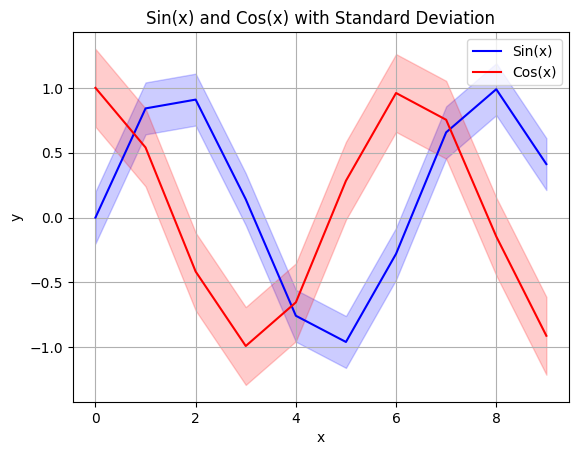

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Data for two sets
x = np.arange(0, 10, 1)
y1 = np.sin(x)
y2 = np.cos(x)

# Standard deviations for each set
std1 = 0.2
std2 = 0.3

# Plotting
plt.plot(x, y1, 'b-', label='Sin(x)')
plt.fill_between(x, y1 - std1, y1 + std1, color='b', alpha=0.2)
plt.plot(x, y2, 'r-', label='Cos(x)')
plt.fill_between(x, y2 - std2, y2 + std2, color='r', alpha=0.2)

# Customizing the plot
plt.title('Sin(x) and Cos(x) with Standard Deviation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)

# Displaying the plot
plt.show()


1/1 [==============================] - 0s 164ms/step


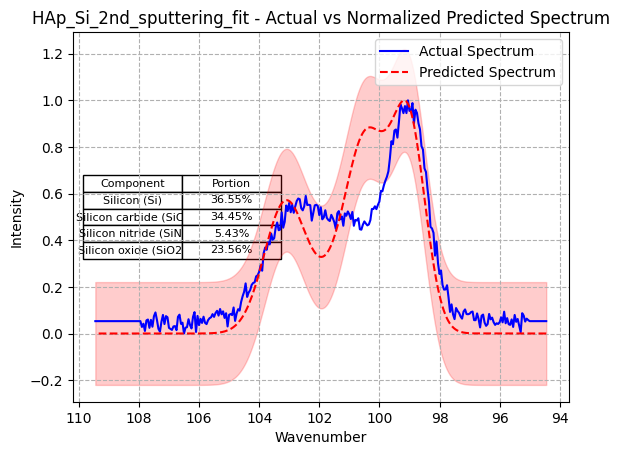

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import os

# Load the saved model
model = load_model('CNN_Model_Component_Binding_Energies_v2.h5')

# Function to generate multiple spectra as a sum of Gaussians
def generate_multiple_spectra(amplitudes, centers, fwhms):
    x_range = np.arange(94.45, 109.45, 0.05)
    all_spectra = []

    for i in range(len(centers)):
        spectrum = np.sum([amplitudes[i] * np.exp(-(x_range - centers[i])**2 / (2 * (fwhms[i] / (2.35482))**2)) for j in range(len(centers))], axis=0)
        all_spectra.append(spectrum)

    final_spectrum = np.sum(all_spectra, axis=0)
    return final_spectrum

# Define components with binding energies and FWHMs
components = {
    'Silicon (Si)': (99, 1.30),
    'Silicon carbide (SiC)': (100.4, 1.65),
    'Silicon nitride (SiN)': (101.6, 1.65),
    'Silicon oxide (SiO2)': (103.1, 1.65)
}

# Load new data from CSV
file_path = 'ExperimentalData/HAp_Si_2nd_sputtering_fit.csv'
data = pd.read_csv(file_path, names=["Wavenumber", "Intensity"])
file_name = os.path.splitext(os.path.basename(file_path))[0]  # Extracts the file name without extension

# Assuming spectrum_min and spectrum_max are defined earlier
spectrum_min, spectrum_max = 94.45, 109.45

data['Wavenumber'] = pd.to_numeric(data['Wavenumber'], errors='coerce')
data['Intensity'] = pd.to_numeric(data['Intensity'], errors='coerce')

# Filter data within the specified wavenumber range
filtered_data = data[(data['Wavenumber'] >= spectrum_min) & (data['Wavenumber'] <= spectrum_max)].copy()
filtered_data = filtered_data.dropna(subset=['Intensity'])

# Preprocess the filtered data
min_value = np.min(filtered_data['Intensity'])
max_value = np.max(filtered_data['Intensity'])
spectraData_normalized = (filtered_data['Intensity'] - min_value) / (max_value - min_value)
filtered_data['Intensity'] = spectraData_normalized

# Prepare data for interpolation
x = filtered_data['Wavenumber']
y = filtered_data['Intensity']
x_normalized = (x - spectrum_min) / (spectrum_max - spectrum_min)

num_specific_frequencies = 4
interpolated_Intensity = np.zeros((num_specific_frequencies, 250))  # Initialize interpolated array
f = interp1d(x_normalized, y, kind='linear', fill_value="extrapolate")
start = 94.45
end = 109.45
step = 0.05
num_points = int((end - start) / step)
new_x = np.linspace(0, 1, num_points)

interpolated_Intensity = f(new_x)
interpolated_Intensity = interpolated_Intensity.reshape(1, -1, num_specific_frequencies)

# Interpolate intensity values
interpolated_intensity = f(new_x)

# Reshape interpolated intensity array
interpolated_intensity = interpolated_intensity.reshape(1, -1, num_specific_frequencies)

# Display the normalized interpolated intensity
predicted_amplitudes = model.predict(interpolated_Intensity)
predicted_amplitudes_flat = predicted_amplitudes.flatten()

# Calculate the spectrum of predicted amplitudes
predicted_spectrum = generate_multiple_spectra(predicted_amplitudes_flat, [comp[0] for comp in components.values()], [comp[1] for comp in components.values()])

# Normalize the predicted spectrum
predicted_spectrum_normalized = (predicted_spectrum - np.min(predicted_spectrum)) / (np.max(predicted_spectrum) - np.min(predicted_spectrum))

# Calculate the total intensity of the predicted spectrum after normalization
total_intensity_normalized = np.sum(predicted_spectrum_normalized)

# Plot both the actual and normalized predicted spectra
plt.plot(filtered_data['Wavenumber'], filtered_data['Intensity'], label='Actual Spectrum', color='blue', linestyle='-')
plt.plot(new_x * (spectrum_max - spectrum_min) + spectrum_min, predicted_spectrum_normalized, label='Predicted Spectrum', color='red', linestyle='--')

# Calculate the standard deviation of the predicted spectrum
std_predicted_spectrum = np.std(predicted_spectrum, axis=0)

# Fill between predicted spectrum +/- 1 standard deviation
plt.fill_between(new_x * (spectrum_max - spectrum_min) + spectrum_min, predicted_spectrum_normalized - std_predicted_spectrum, predicted_spectrum_normalized + std_predicted_spectrum, color='red', alpha=0.2)

# Add a table with labels for the portions of each component based on predicted amplitudes
total_intensity = np.sum(predicted_amplitudes_flat)
table_data = [['Component', 'Portion']]
for component_name, (component_energy, _) in components.items():
    component_amplitude = predicted_amplitudes_flat[list(components.keys()).index(component_name)]
    portion = component_amplitude / total_intensity
    table_data.append([component_name, f'{portion * 100:.2f}%'])

# Create a table with custom font properties
table = plt.table(cellText=table_data, loc='center left', colWidths=[0.2, 0.2], cellLoc='center', colLabels=None)
table.auto_set_font_size(False)
table.set_fontsize(8)

# Add file name to the plot title
plt.title(f'{file_name} - Actual vs Normalized Predicted Spectrum')

plt.xlabel('Wavenumber')
plt.ylabel('Intensity')
plt.legend()
plt.gca().invert_xaxis()
plt.grid(True, which="both", ls="--")
plt.show()


The shaded region in the plot represents the standard deviation of the predicted spectrum, which is a measure of the dispersion or variability of the prediction around the mean predicted values. Here are some insights into the interpretation of the shaded region and the model's predictions:

Overlap with Actual Spectrum: If the shaded region closely follows the actual spectrum (the blue line), it indicates that the model's predictions are in good agreement with the actual data. In this plot, there are areas where the predicted spectrum (red dashed line) overlaps well with the actual spectrum, particularly around the peaks, suggesting decent predictive performance in those regions.

Width of the Shaded Region: The narrower the shaded region, the less uncertainty there is in the model's predictions. In this plot, the shaded region varies in width, implying that the model's certainty in its predictions also varies across the spectrum.

Consistency of Predictions: In areas where the predicted spectrum consistently falls within the shaded region of the actual spectrum, it suggests the model has a consistent prediction quality. However, if there are parts of the actual spectrum that consistently fall outside of the shaded region of the prediction, it may indicate systematic errors in the model's predictions or regions where the model is less accurate.

Peaks and Troughs: The model seems to capture the general trend of the spectrum, as seen by the alignment of the peaks and troughs in both the predicted and actual spectra. However, there are discrepancies in the height and width of these features, which could suggest limitations in the model's ability to capture the exact shape of the spectral features.

In [5]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')
# Change working path
os.chdir('/content/drive/MyDrive/Research/XPS')

Mounted at /content/drive
